In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()
    
# https://dacon.io/en/competitions/open/235736/codeshare/2877?page=1&dtype=recent
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100    

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [5]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [6]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [7]:
# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [8]:
# outlier 제거 
train = train[train['전력소비량(kWh)'] > 1]

In [9]:
target_encoding = train.groupby(['건물유형']).agg({'전력소비량(kWh)':['min', 'mean','max']}).reset_index()
target_encoding.columns = ['건물유형', 'khw_min', 'khw_mean', 'khw_max']
train = train.merge(target_encoding, on=['건물유형'], how='left')
test = test.merge(target_encoding, on=['건물유형'], how='left')

In [10]:
power_mean = pd.pivot_table(train, values = '전력소비량(kWh)', index = ['건물번호', 'time', 'day'], aggfunc = np.mean).reset_index()
power_mean = power_mean.rename(columns={'전력소비량(kWh)':'day_hour_mean'})

In [11]:
train = train.merge(power_mean, on=['건물번호', 'time', 'day'])
test = test.merge(power_mean, on=['건물번호', 'time', 'day'])

In [12]:
train.drop( train[(train['건물번호'].isin([1,16])) & (train['month'] == 6)].index, inplace=True)

In [13]:
no_work_day = train.groupby(['건물번호', '건물유형','month', 'day']).agg({'전력소비량(kWh)':['mean','max']}).reset_index()
no_work_day.columns = ['건물번호', '건물유형','month', 'day', 'khw_mean', 'khw_max']
total_mean = no_work_day[no_work_day['건물유형'].isin(['백화점및아울렛','할인마트'])].groupby(['건물번호']).khw_mean.mean().reset_index().rename(columns={'khw_mean':'b_mean'})

no_work_day = no_work_day.merge(total_mean, on='건물번호')
no_work_day.loc[no_work_day.b_mean > no_work_day.khw_max, '백화점휴무일'] = 1

train = train.merge(no_work_day[['건물번호', '건물유형','month', 'day', '백화점휴무일']], on=['건물번호', '건물유형','month', 'day'], how='left')
train['백화점휴무일'] = train['백화점휴무일'].fillna(0).astype(int)
test['백화점휴무일'] = 0

In [14]:
train['냉방비율'] = ((train['냉방면적(m2)'] / train['연면적(m2)'])*100 ).astype(int)
test['냉방비율'] = ((test['냉방면적(m2)'] / test['연면적(m2)'])*100 ).astype(int)

train = train.drop(columns=['연면적(m2)','냉방면적(m2)'])
test = test.drop(columns=['연면적(m2)','냉방면적(m2)'])

In [15]:
#결측값을 0으로 채웁니다
train = train.fillna(0)
test = test.fillna(0)

In [16]:
# train.drop('풍속(m/s)', axis=1, inplace=True)
# test.drop('풍속(m/s)', axis=1, inplace=True)

In [17]:
# 공휴일 제외 
print(train.shape)
train['dates'] = train['일시'].apply(lambda x : int(x[:8]))
# train = train[~((train['dates'].isin([20220606,20220615])) & (train['건물유형'].isin(['공공','병원'])))]
train['holiday'] = 0
test['holiday'] = 0
train.loc[train['dates'].isin([20220606,20220615]), 'holiday'] = 1

train.drop(['dates'], axis=1, inplace=True)
train.shape

(202558, 24)


(202558, 25)

In [18]:
## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.time/24)
train['cos_time'] = np.cos(2*np.pi*train.time/24)
test['sin_time'] = np.sin(2*np.pi*test.time/24)
test['cos_time'] = np.cos(2*np.pi*test.time/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['기온(C)'] - 0.55*(1-train['습도(%)']/100)*(9/5*train['습도(%)']-26)+32
test['THI'] = 9/5*test['기온(C)'] - 0.55*(1-test['습도(%)']/100)*(9/5*test['습도(%)']-26)+32

In [19]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])

for num in train['건물번호'].unique():
    temp = train[train['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

cdhs = np.array([])
for num in test['건물번호'].unique():
    temp = test[test['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

In [20]:
days = [18, 19, 20, 21, 22, 23, 24]

X_train = train[~((train['month'] == 8) & (train['day'].isin(days)))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_train = train[~((train['month'] == 8) & (train['day'].isin(days)))]['전력소비량(kWh)']

X_test = train[(train['month'] == 8) & (train['day'].isin(days))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_test = train[(train['month'] == 8) & (train['day'].isin(days))]['전력소비량(kWh)']


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(185758, 24) (16800, 24) (185758,) (16800,)


In [21]:
#결측값을 0으로 채웁니다
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

## Regression Model Fit

,건물유형,유형별_score
0,건물기타,5.527409


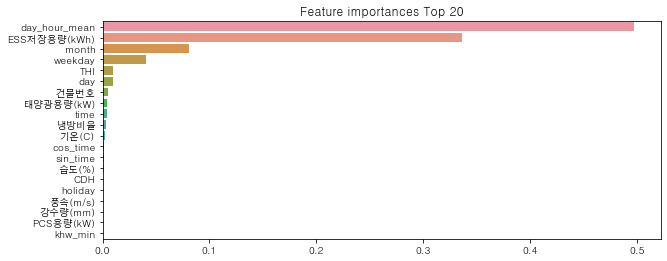

,건물유형,유형별_score
0,공공,3.881909


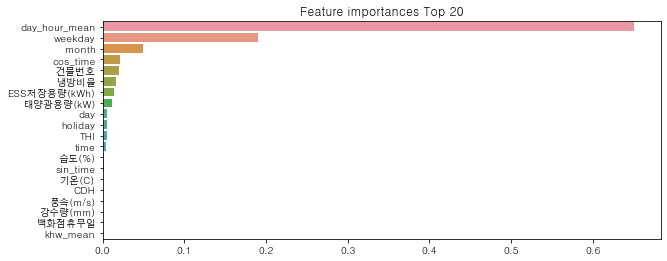

,건물유형,유형별_score
0,대학교,3.523553


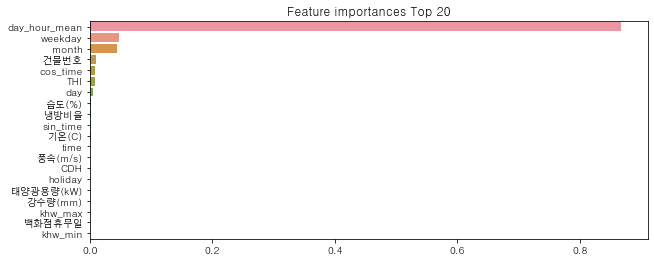

,건물유형,유형별_score
0,데이터센터,0.292442


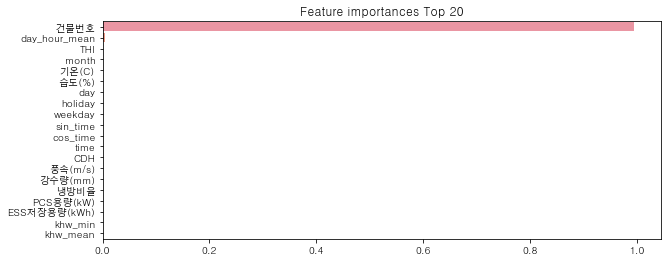

,건물유형,유형별_score
0,백화점및아울렛,3.777105


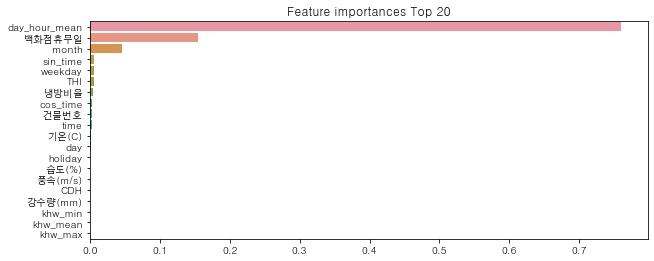

,건물유형,유형별_score
0,병원,2.403966


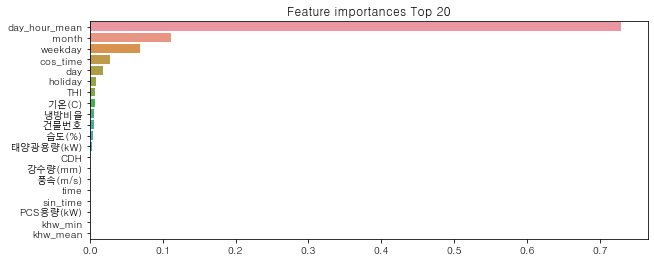

,건물유형,유형별_score
0,상용,4.485122


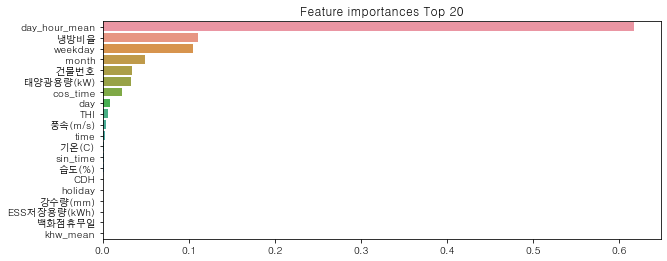

,건물유형,유형별_score
0,아파트,3.174902


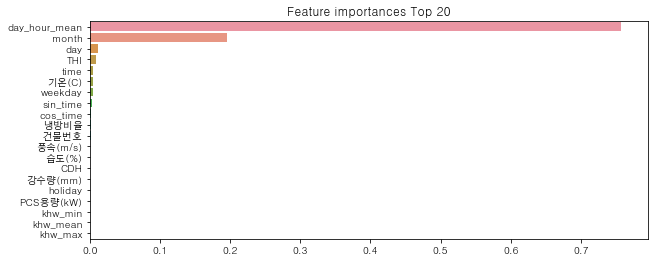

,건물유형,유형별_score
0,연구소,3.157091


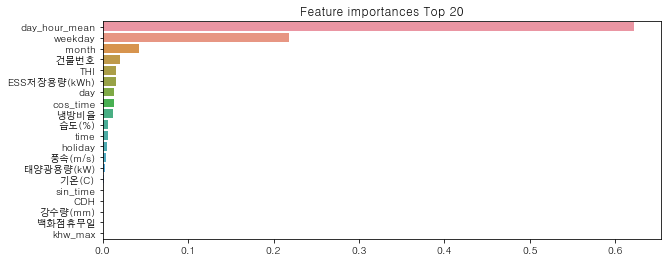

,건물유형,유형별_score
0,지식산업센터,3.13781


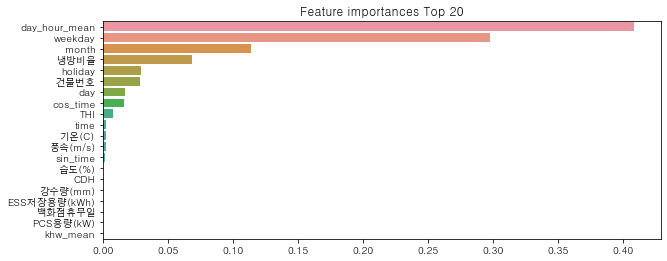

,건물유형,유형별_score
0,할인마트,3.912421


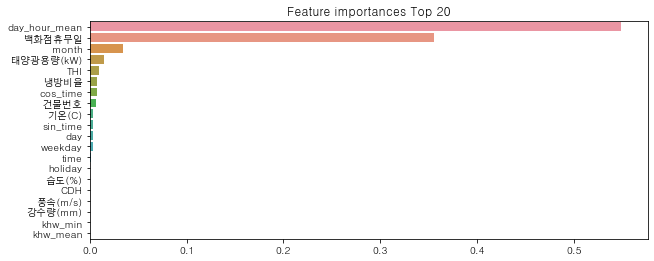

,건물유형,유형별_score
0,호텔및리조트,5.480892


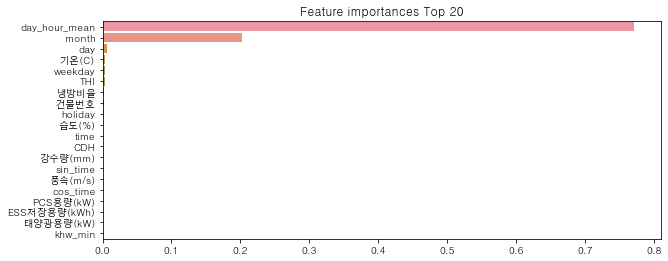

Wall time: 49.3 s


In [22]:
%%time 
metrics_type = pd.DataFrame()
for i in train['건물유형'].unique():
    temp_X_train = X_train[X_train['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':weighted_mse(100)})
    
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, SMAPE(temp_y_test, y_preds)]).T
    temp.columns = ['건물유형', '유형별_score']
    metrics_type = metrics_type.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    

,건물번호,건물별_score
0,1.0,3.290176


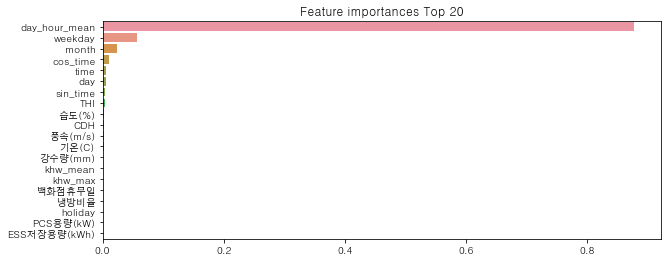

,건물번호,건물별_score
0,2.0,4.693152


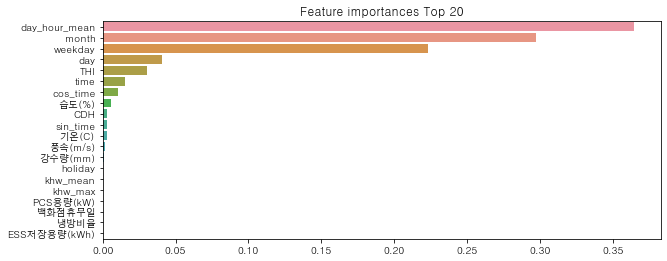

,건물번호,건물별_score
0,3.0,8.617103


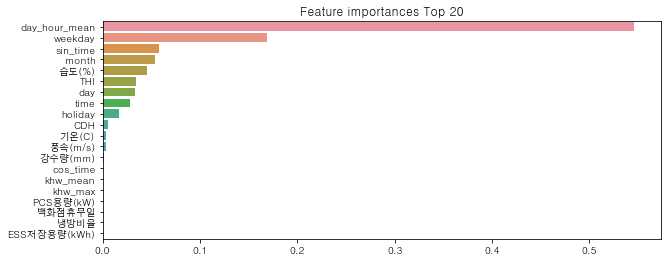

,건물번호,건물별_score
0,4.0,2.566335


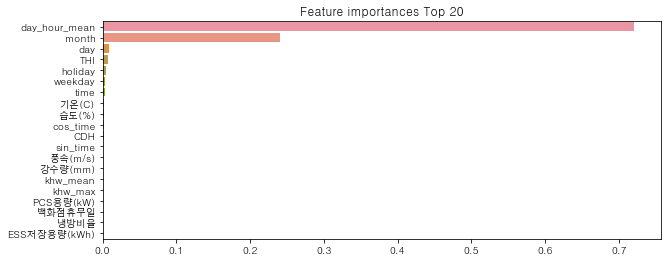

,건물번호,건물별_score
0,5.0,4.021523


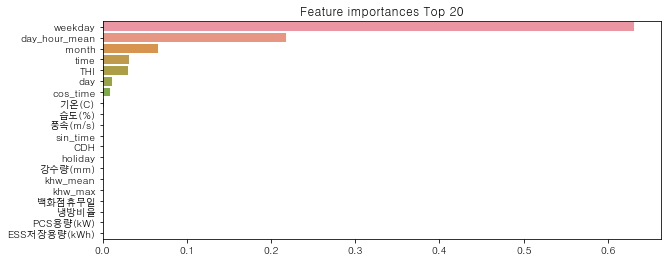

,건물번호,건물별_score
0,6.0,1.525816


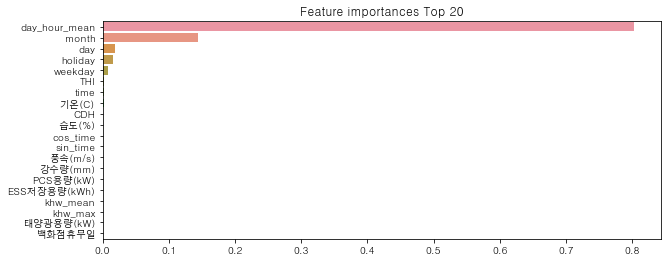

,건물번호,건물별_score
0,7.0,4.518064


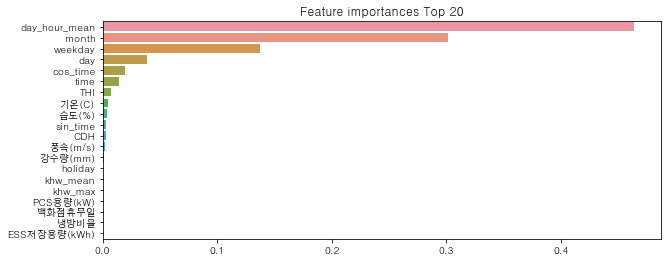

,건물번호,건물별_score
0,8.0,2.803076


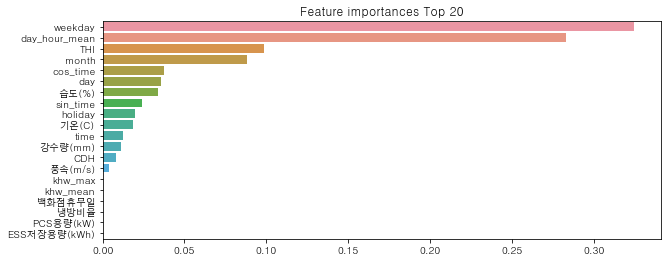

,건물번호,건물별_score
0,9.0,2.526559


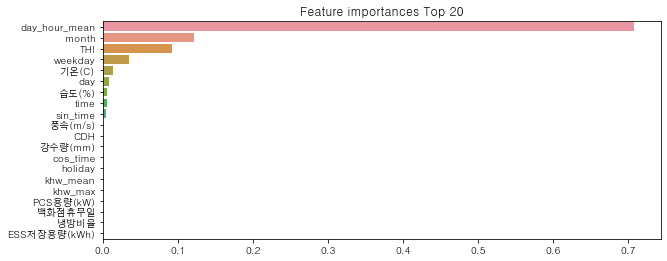

,건물번호,건물별_score
0,10.0,4.419472


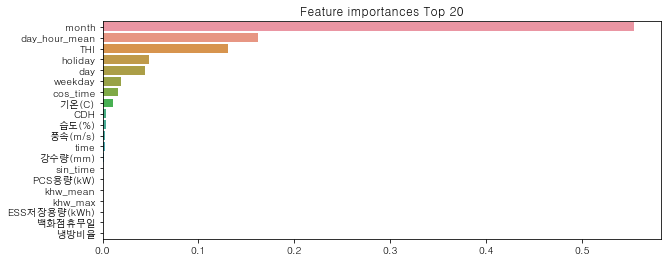

,건물번호,건물별_score
0,11.0,1.618018


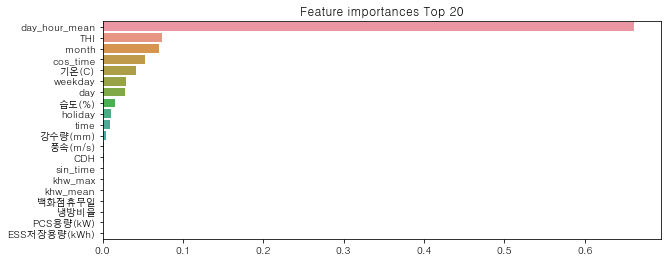

,건물번호,건물별_score
0,12.0,1.880958


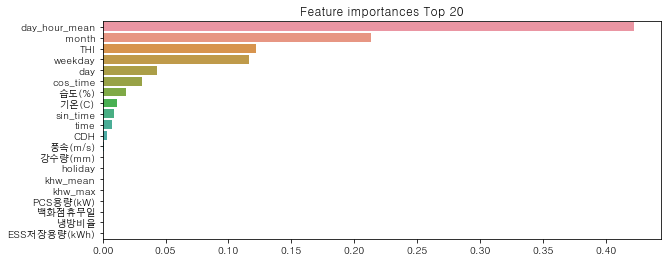

,건물번호,건물별_score
0,13.0,5.647008


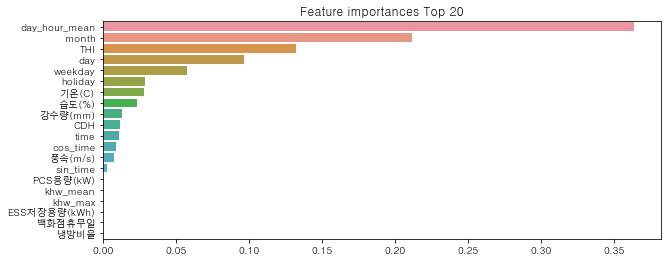

,건물번호,건물별_score
0,14.0,8.134656


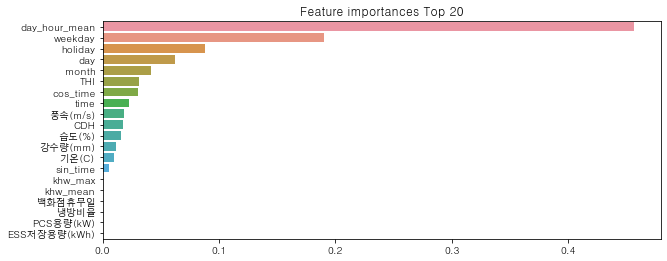

,건물번호,건물별_score
0,15.0,1.74418


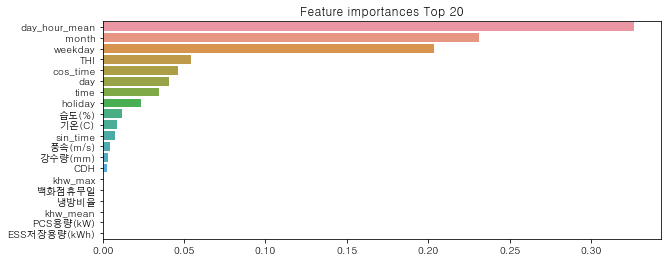

,건물번호,건물별_score
0,16.0,2.639108


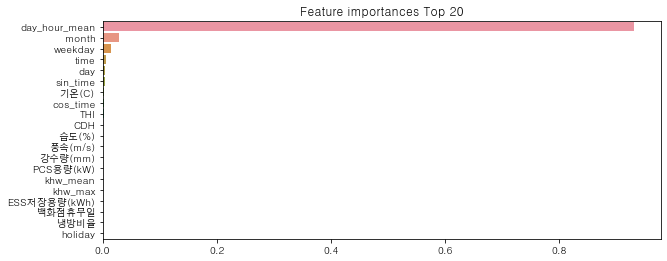

,건물번호,건물별_score
0,17.0,2.789114


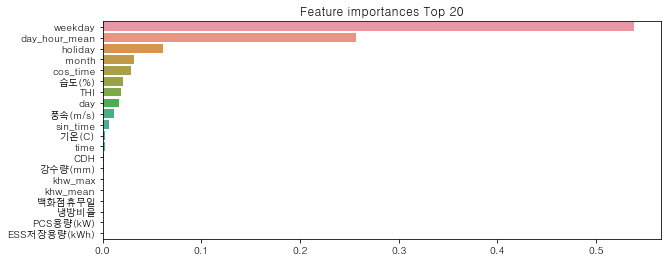

,건물번호,건물별_score
0,18.0,3.056441


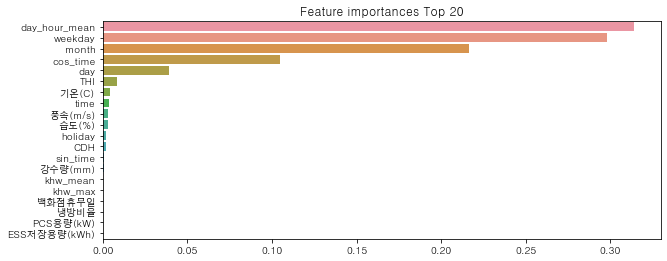

,건물번호,건물별_score
0,19.0,3.772616


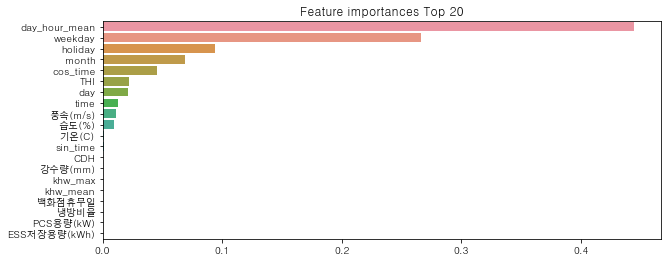

,건물번호,건물별_score
0,20.0,2.673456


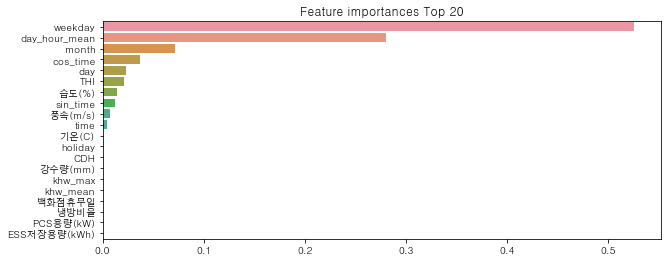

,건물번호,건물별_score
0,21.0,2.955905


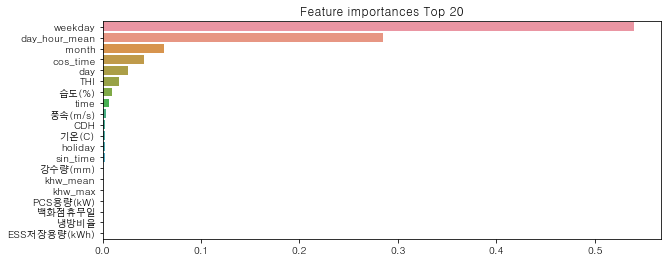

,건물번호,건물별_score
0,22.0,2.28051


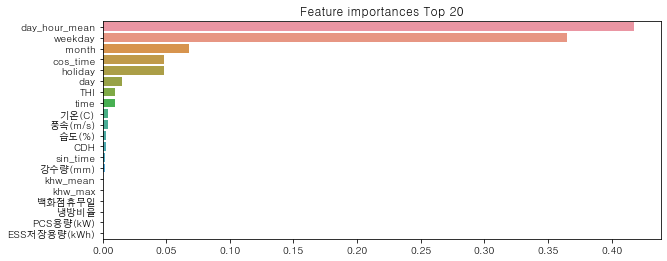

,건물번호,건물별_score
0,23.0,1.343457


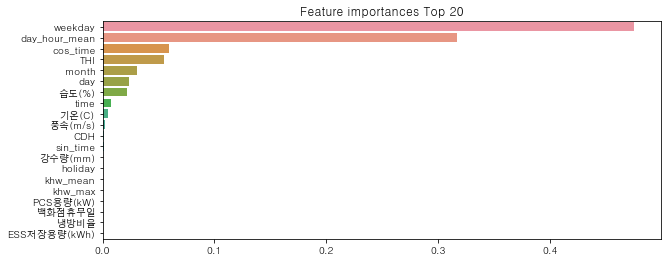

,건물번호,건물별_score
0,24.0,1.283623


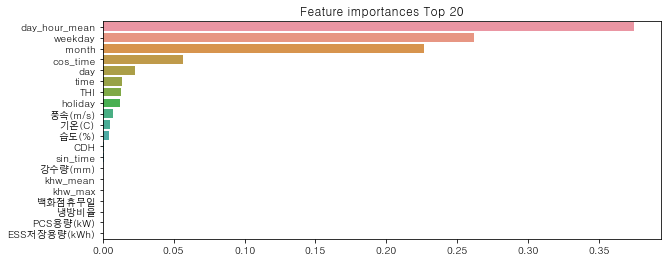

,건물번호,건물별_score
0,25.0,1.510501


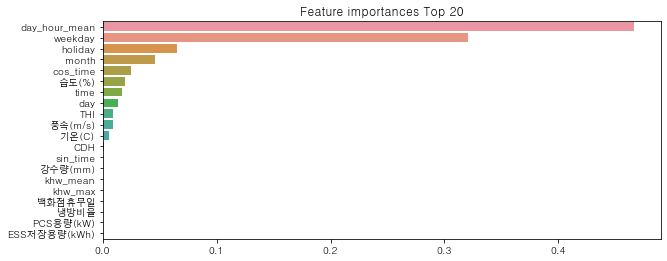

,건물번호,건물별_score
0,26.0,1.440866


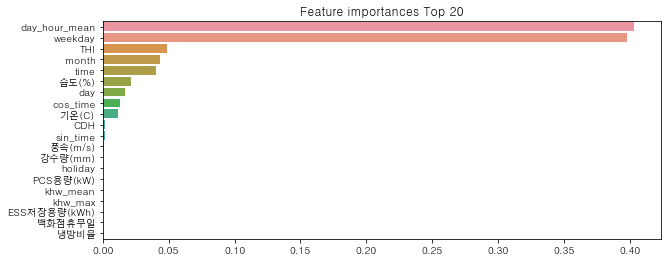

,건물번호,건물별_score
0,27.0,1.276123


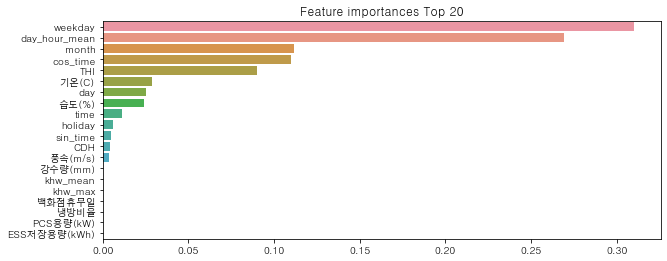

,건물번호,건물별_score
0,28.0,3.106496


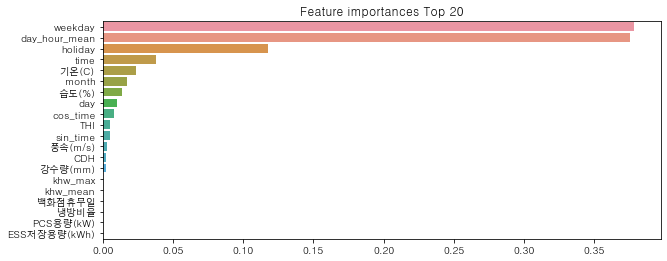

,건물번호,건물별_score
0,29.0,2.340018


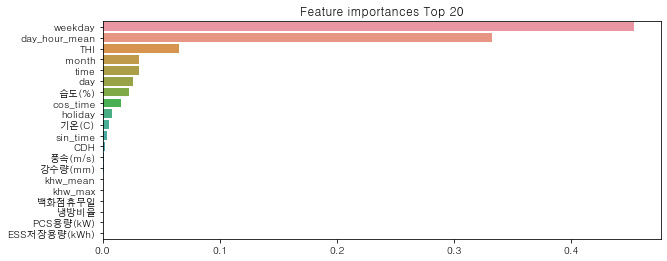

,건물번호,건물별_score
0,30.0,3.702531


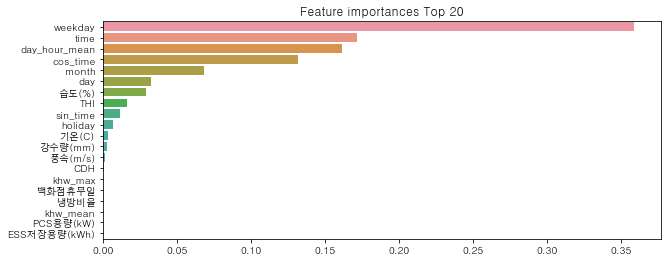

,건물번호,건물별_score
0,31.0,2.733929


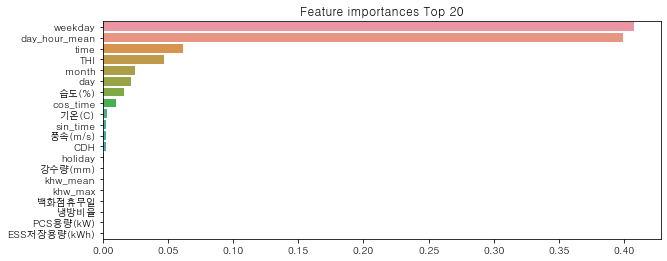

,건물번호,건물별_score
0,32.0,0.208071


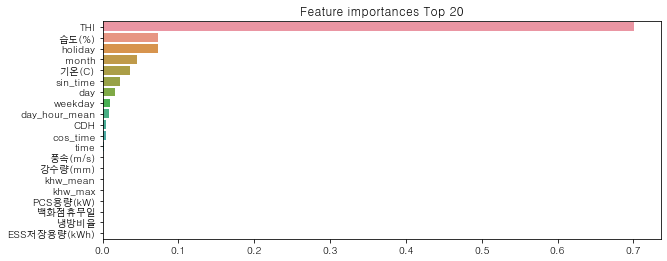

,건물번호,건물별_score
0,33.0,0.223662


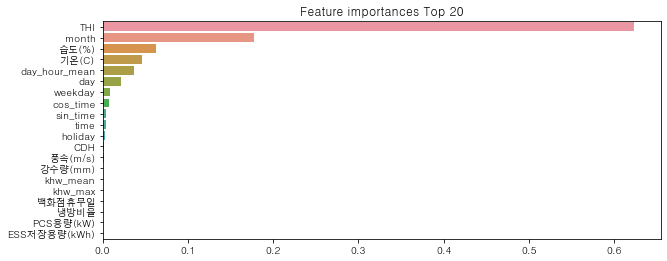

,건물번호,건물별_score
0,34.0,0.331203


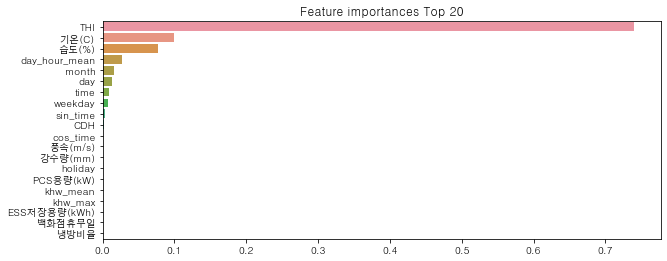

,건물번호,건물별_score
0,35.0,0.217942


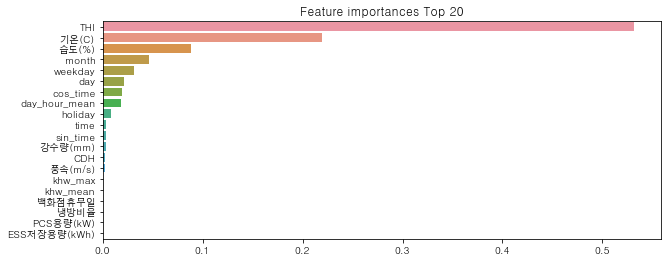

,건물번호,건물별_score
0,36.0,0.355206


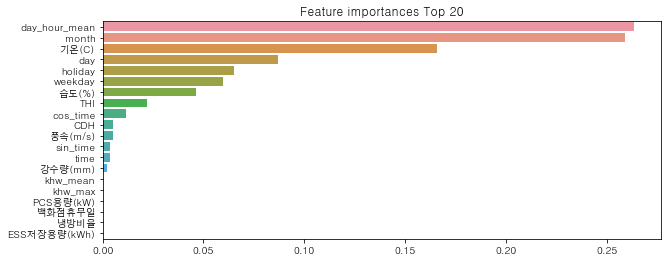

,건물번호,건물별_score
0,37.0,2.187984


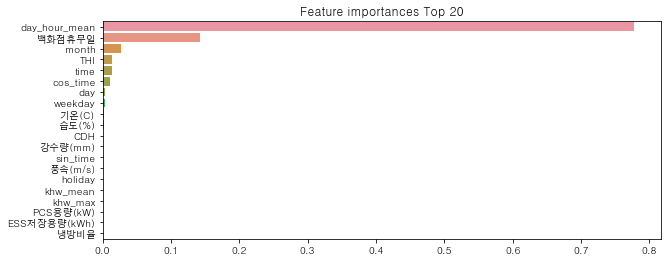

,건물번호,건물별_score
0,38.0,2.341816


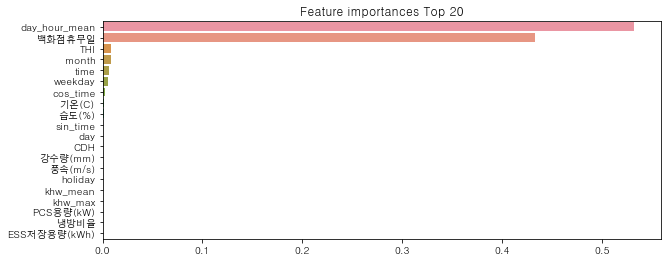

,건물번호,건물별_score
0,39.0,2.029459


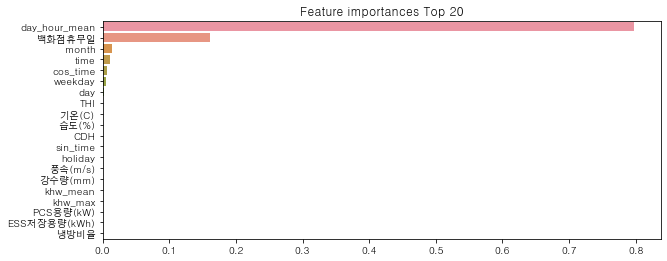

,건물번호,건물별_score
0,40.0,5.078755


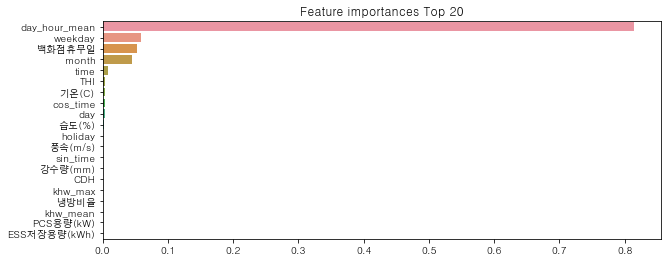

,건물번호,건물별_score
0,41.0,1.957103


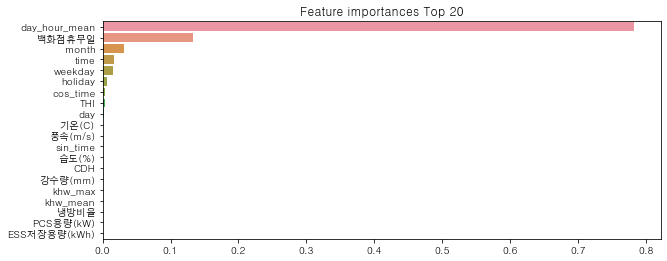

,건물번호,건물별_score
0,42.0,3.087609


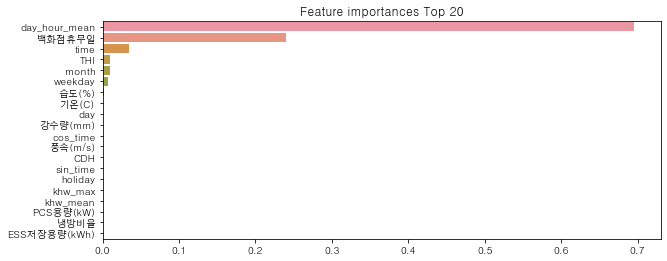

,건물번호,건물별_score
0,43.0,3.977242


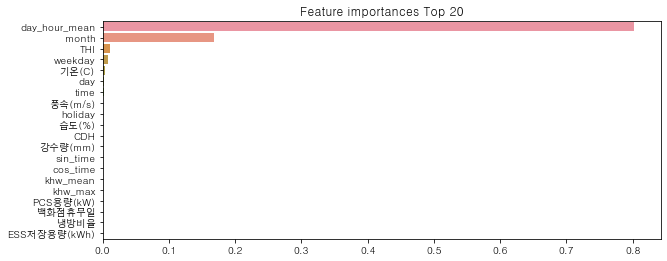

,건물번호,건물별_score
0,44.0,1.903963


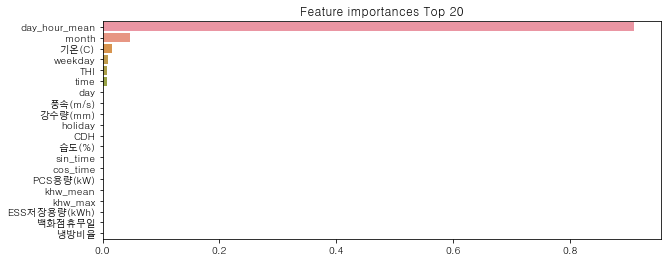

,건물번호,건물별_score
0,45.0,1.359079


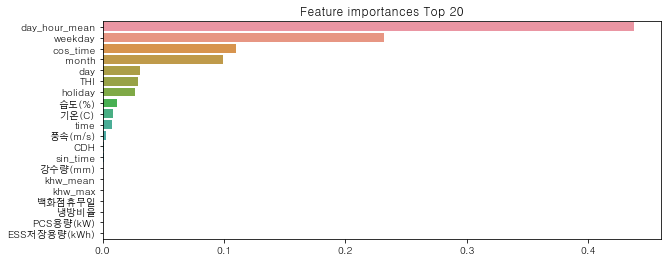

,건물번호,건물별_score
0,46.0,3.055471


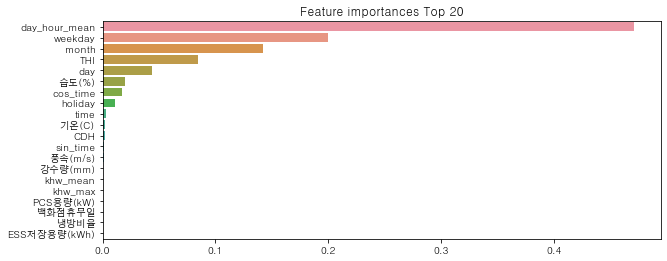

,건물번호,건물별_score
0,47.0,2.325794


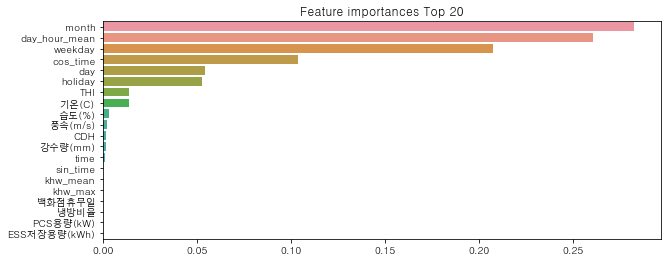

,건물번호,건물별_score
0,48.0,1.547023


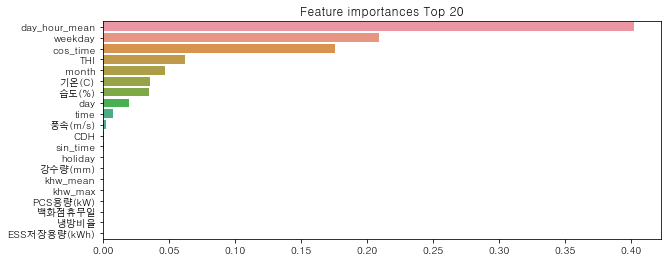

,건물번호,건물별_score
0,49.0,1.919241


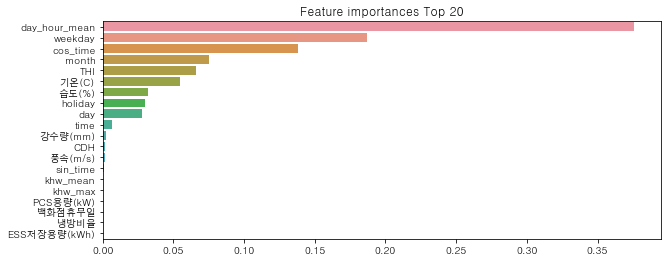

,건물번호,건물별_score
0,50.0,1.358161


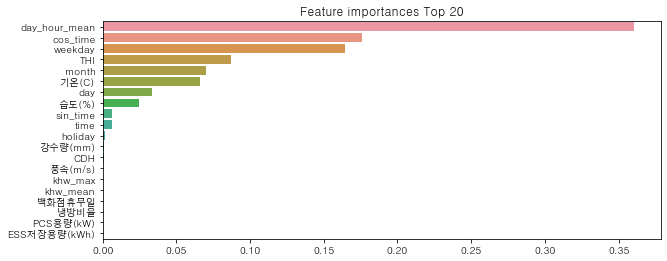

,건물번호,건물별_score
0,51.0,2.273987


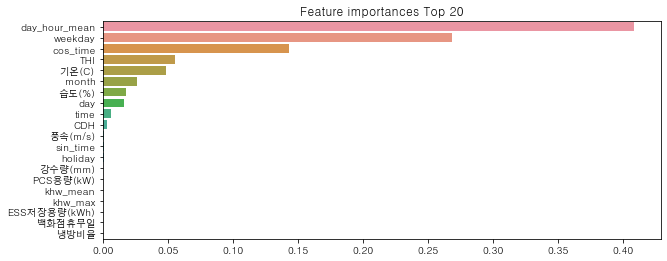

,건물번호,건물별_score
0,52.0,1.808639


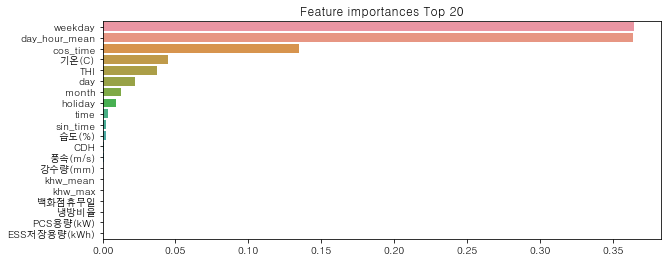

,건물번호,건물별_score
0,53.0,5.212148


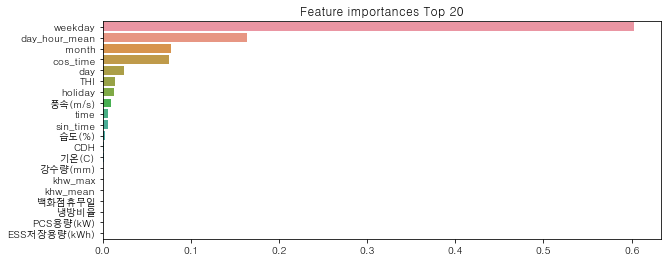

,건물번호,건물별_score
0,54.0,12.130028


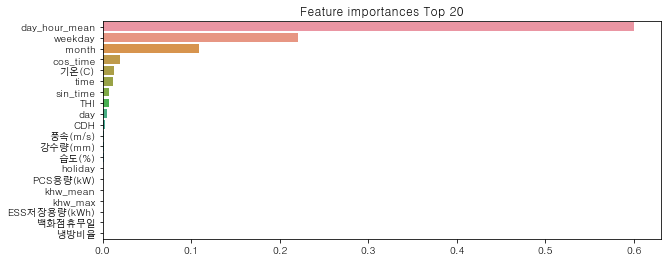

,건물번호,건물별_score
0,55.0,0.780482


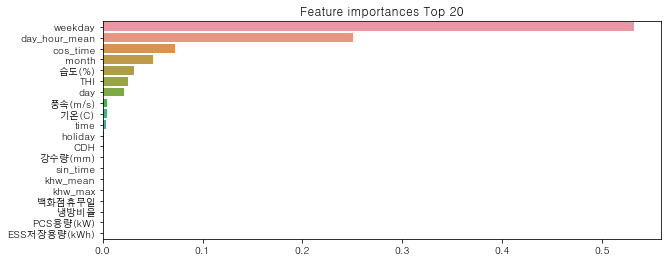

,건물번호,건물별_score
0,56.0,0.512844


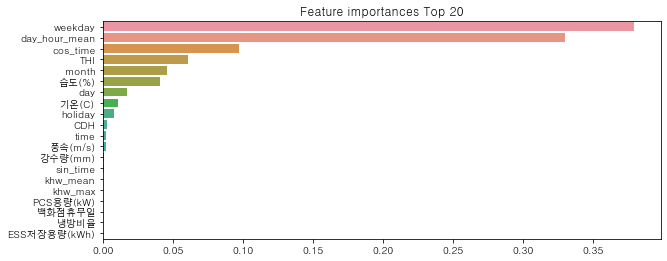

,건물번호,건물별_score
0,57.0,2.836154


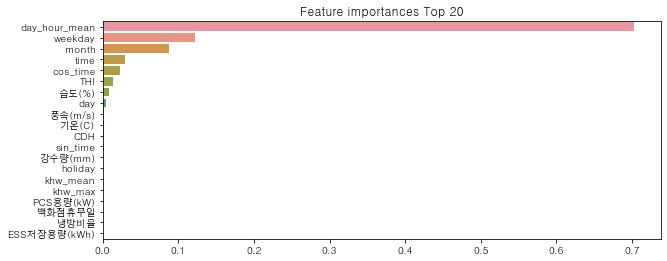

,건물번호,건물별_score
0,58.0,0.224805


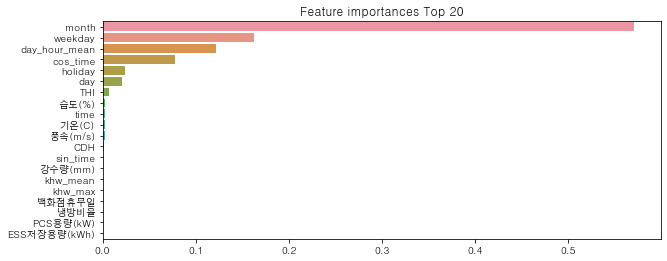

,건물번호,건물별_score
0,59.0,3.653306


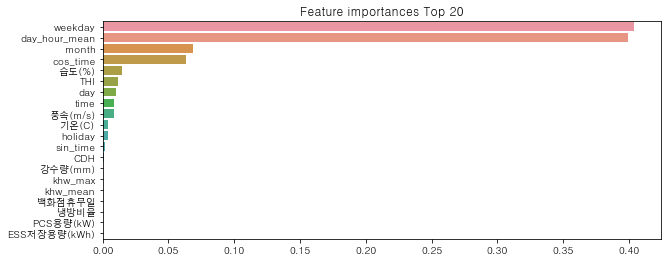

,건물번호,건물별_score
0,60.0,3.149757


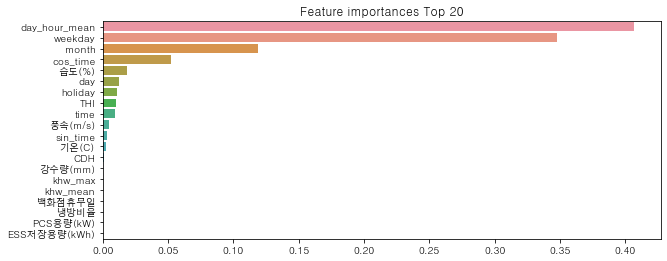

,건물번호,건물별_score
0,61.0,2.746004


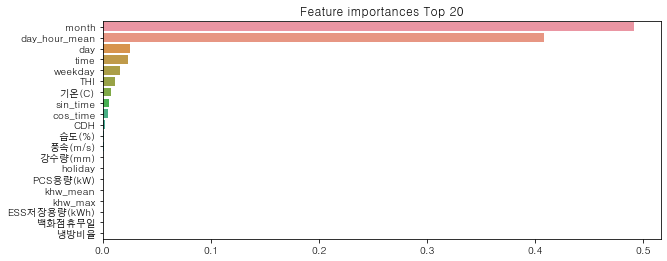

,건물번호,건물별_score
0,62.0,2.692311


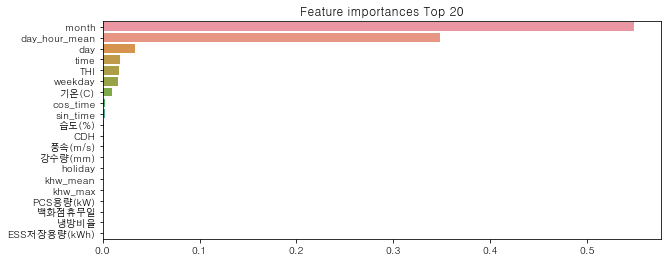

,건물번호,건물별_score
0,63.0,3.565073


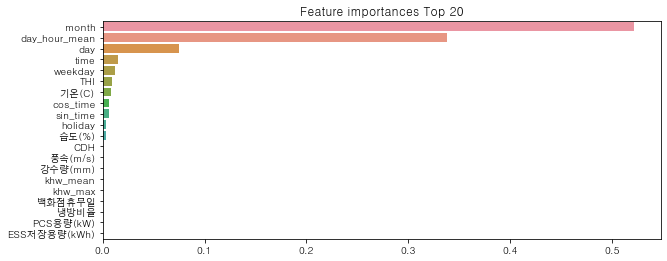

,건물번호,건물별_score
0,64.0,2.505452


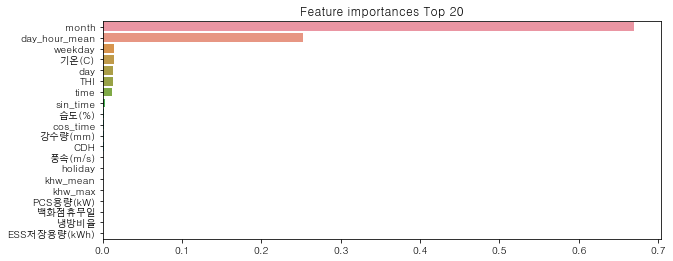

,건물번호,건물별_score
0,65.0,4.047152


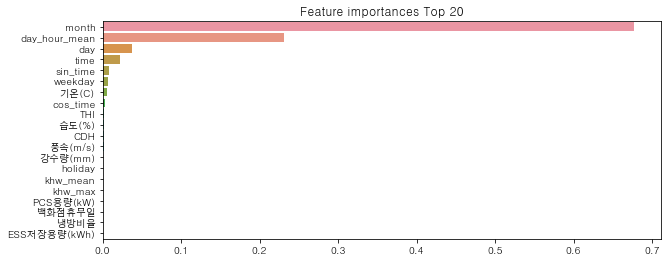

,건물번호,건물별_score
0,66.0,3.938549


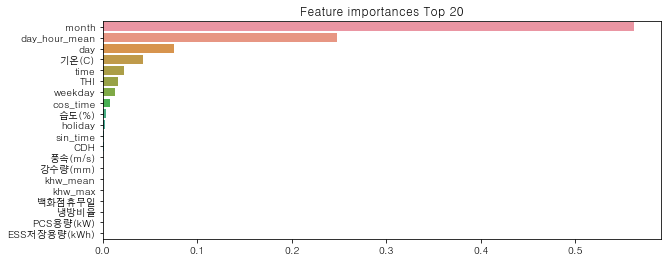

,건물번호,건물별_score
0,67.0,3.542437


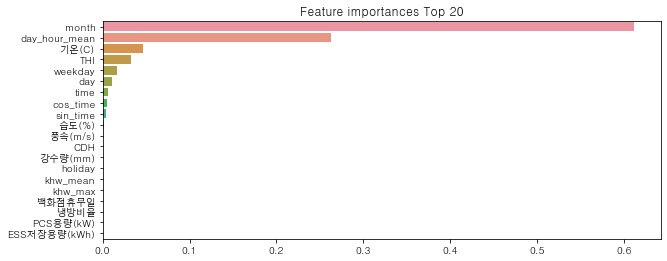

,건물번호,건물별_score
0,68.0,2.017884


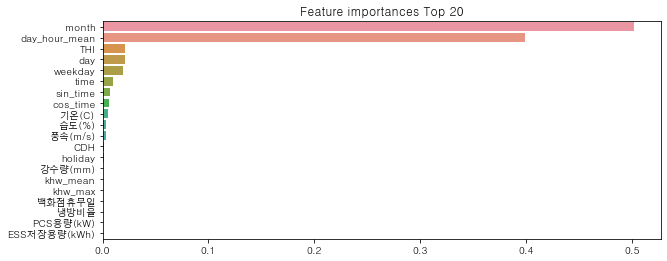

,건물번호,건물별_score
0,69.0,1.422147


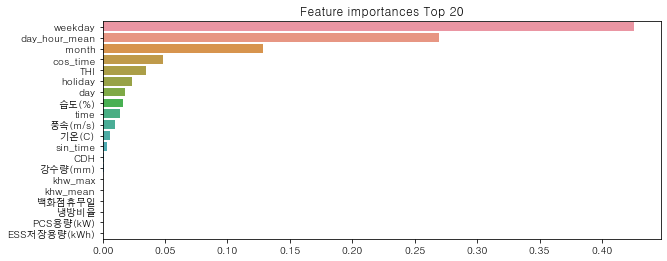

,건물번호,건물별_score
0,70.0,2.17873


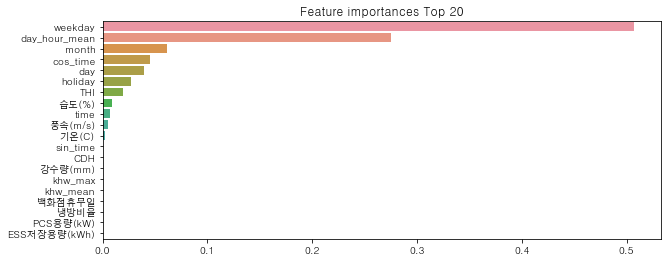

,건물번호,건물별_score
0,71.0,1.9721


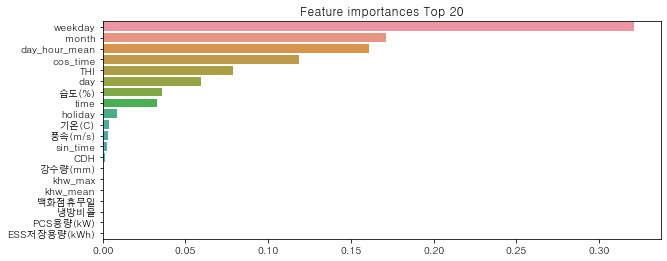

,건물번호,건물별_score
0,72.0,2.334926


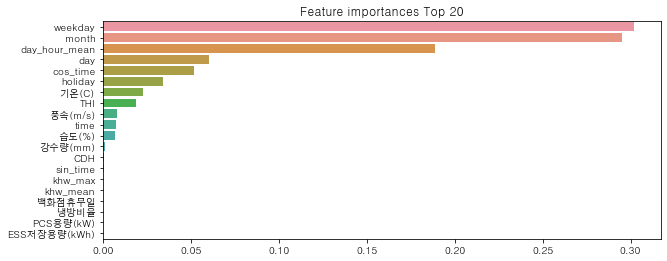

,건물번호,건물별_score
0,73.0,2.253149


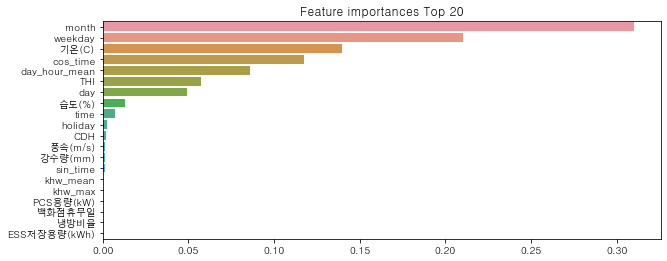

,건물번호,건물별_score
0,74.0,2.983172


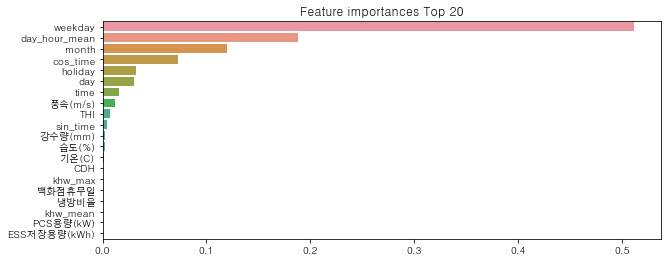

,건물번호,건물별_score
0,75.0,2.818565


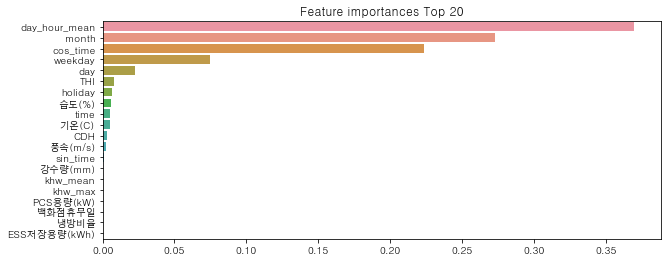

,건물번호,건물별_score
0,76.0,3.046419


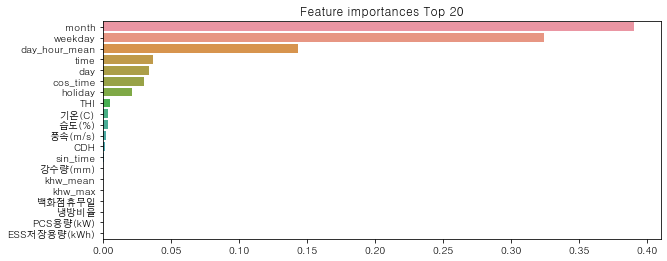

,건물번호,건물별_score
0,77.0,1.56951


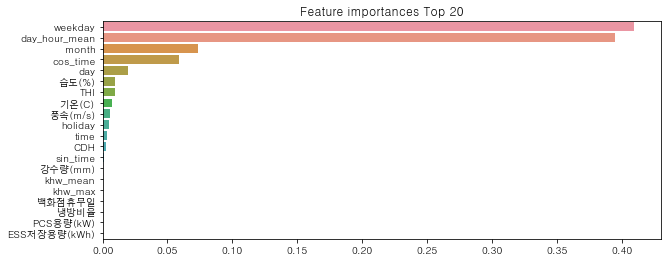

,건물번호,건물별_score
0,78.0,2.297273


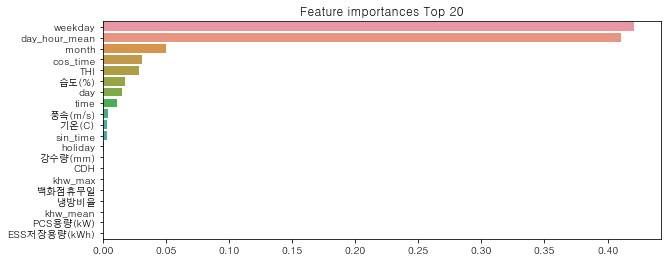

,건물번호,건물별_score
0,79.0,1.590538


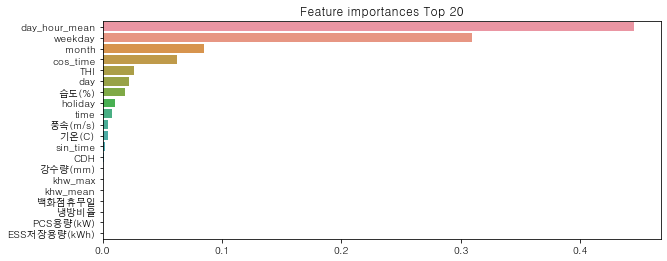

,건물번호,건물별_score
0,80.0,3.261556


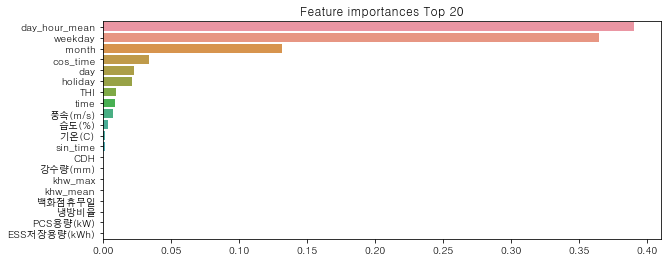

,건물번호,건물별_score
0,81.0,1.894021


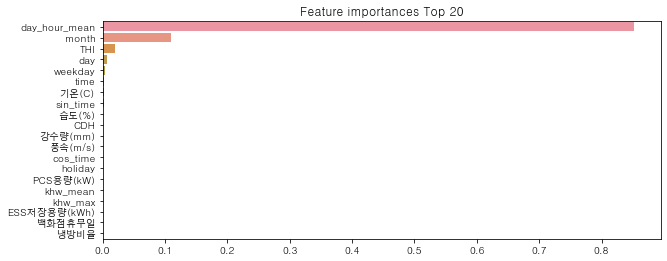

,건물번호,건물별_score
0,82.0,3.260512


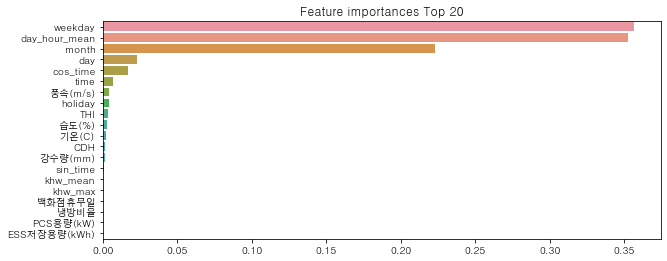

,건물번호,건물별_score
0,83.0,1.739471


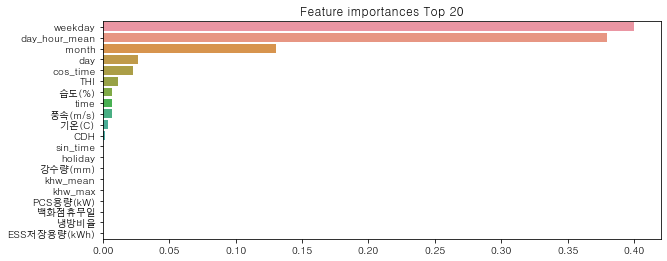

,건물번호,건물별_score
0,84.0,1.815389


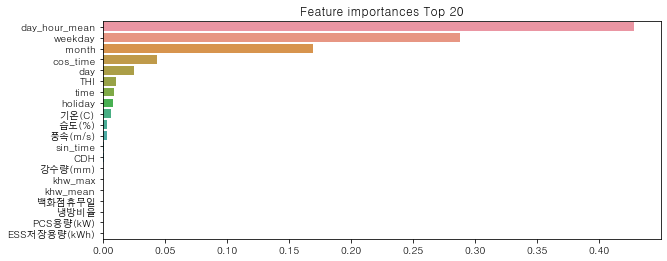

,건물번호,건물별_score
0,85.0,1.702744


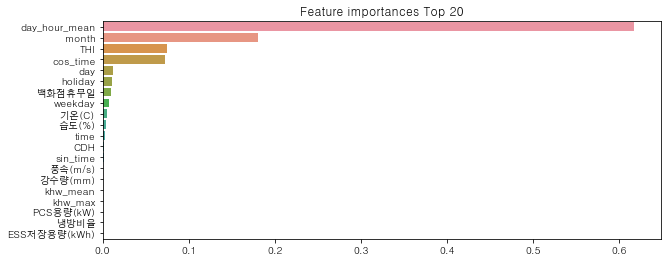

,건물번호,건물별_score
0,86.0,2.282701


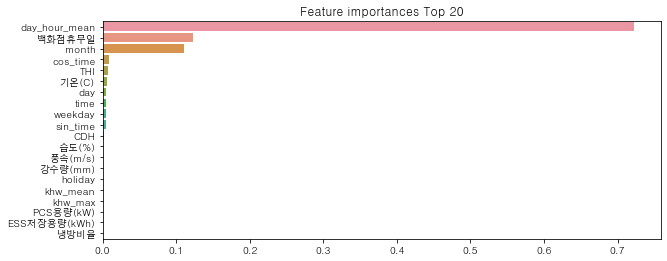

,건물번호,건물별_score
0,87.0,4.14363


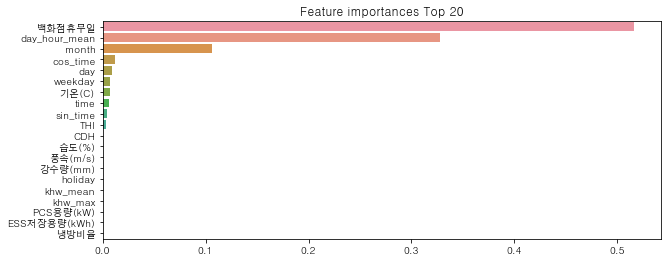

,건물번호,건물별_score
0,88.0,1.962794


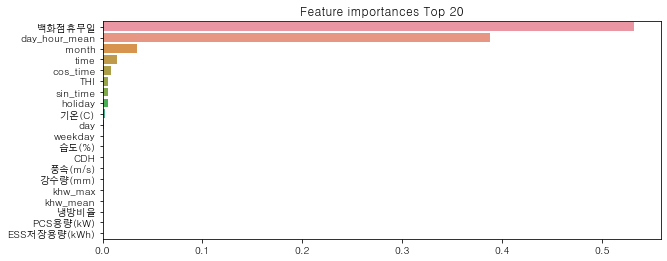

,건물번호,건물별_score
0,89.0,2.42479


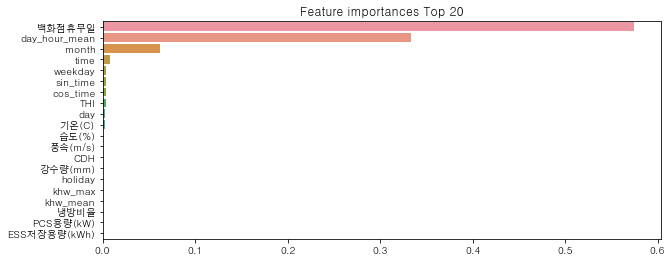

,건물번호,건물별_score
0,90.0,2.968691


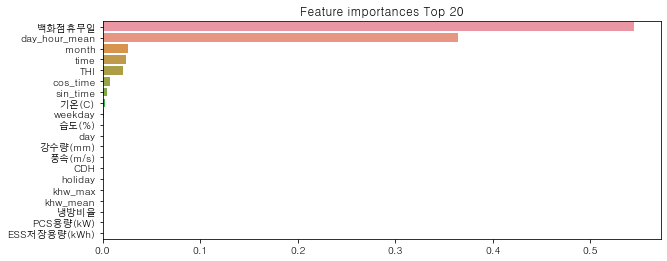

,건물번호,건물별_score
0,91.0,4.750024


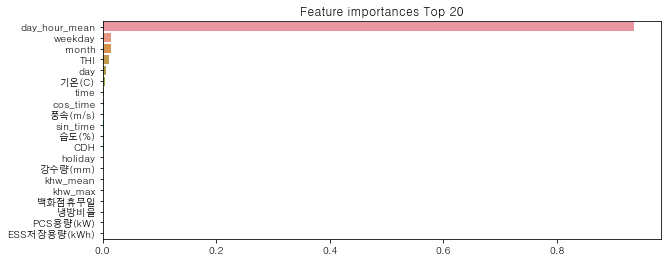

,건물번호,건물별_score
0,92.0,2.516849


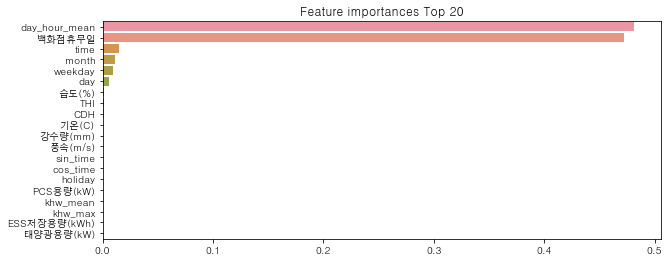

,건물번호,건물별_score
0,93.0,2.243472


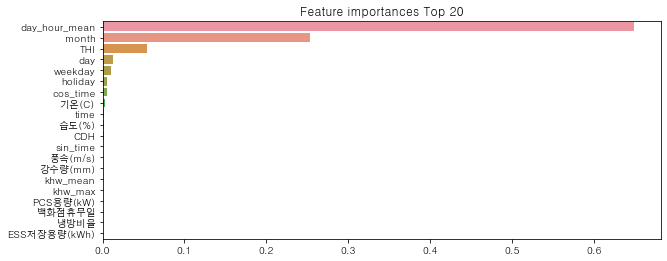

,건물번호,건물별_score
0,94.0,3.345717


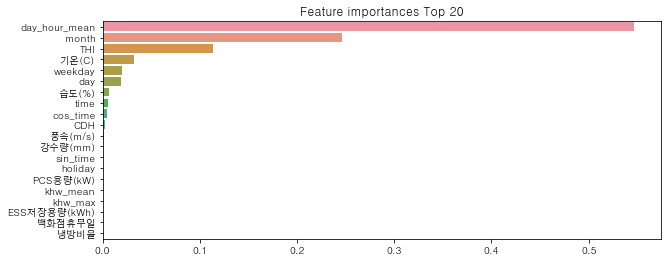

,건물번호,건물별_score
0,95.0,7.268768


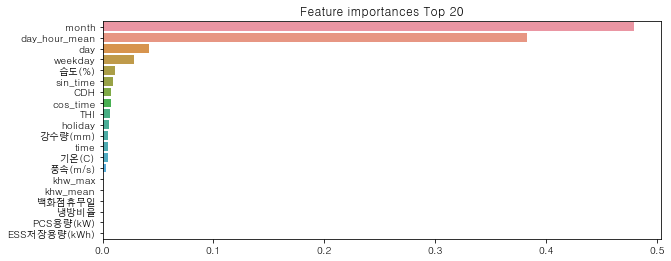

,건물번호,건물별_score
0,96.0,1.854963


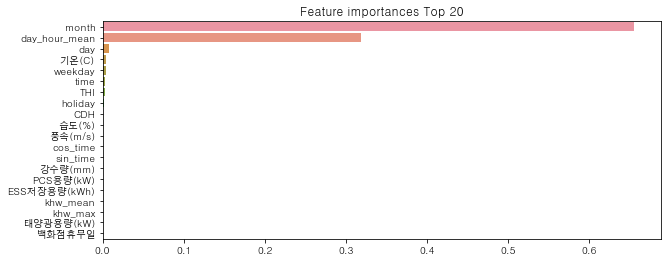

,건물번호,건물별_score
0,97.0,2.892535


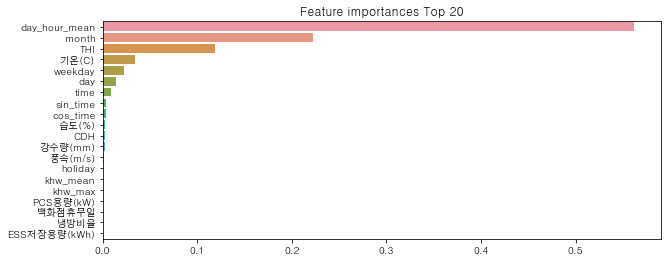

,건물번호,건물별_score
0,98.0,5.941756


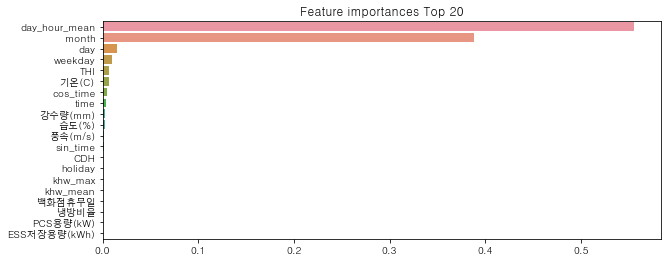

,건물번호,건물별_score
0,99.0,2.177958


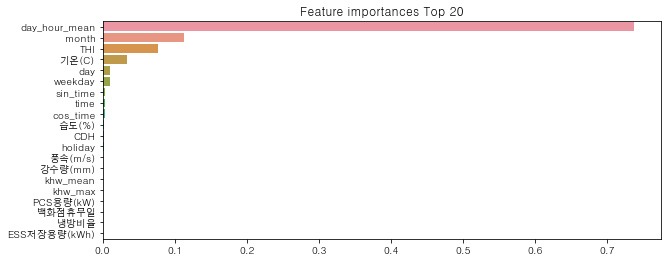

,건물번호,건물별_score
0,100.0,3.638095


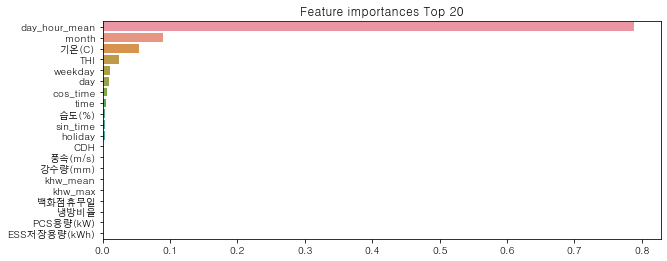


Wall time: 1min 35s


In [23]:
%%time 
metrics_bno = pd.DataFrame()
for i in train['건물번호'].unique():

    temp_X_train = X_train[X_train['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
        
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':weighted_mse(100)})
    
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, SMAPE(temp_y_test, y_preds)]).T
    temp.columns = ['건물번호', '건물별_score']
    metrics_bno = metrics_bno.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    print()

In [24]:
metrics_bno['건물번호'] = metrics_bno['건물번호'].astype(int)

In [25]:
metrics_bno = metrics_bno.merge(building_info[['건물유형','건물번호']], on=['건물번호'])

In [26]:
metrics = metrics_bno.merge(metrics_type, on=['건물유형'])
metrics[:2]

,건물번호,건물별_score,건물유형,유형별_score
0,1,3.290176,건물기타,5.527409
1,2,4.693152,건물기타,5.527409


In [27]:
# 유형보다 건물이 더 좋은 스코어를 가지는 건물번호 list
bno = metrics[metrics['건물별_score'] < metrics['유형별_score']]['건물번호'].values
len(bno), bno

(79,
 array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         31,  32,  33,  35,  37,  38,  39,  41,  42,  44,  45,  47,  48,
         49,  50,  51,  52,  55,  56,  57,  58,  59,  60,  61,  62,  64,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,
         83,  84,  85,  86,  88,  89,  90,  92,  93,  94,  96,  97,  99,
        100]))

In [28]:
metrics_type['유형별_score'].mean(), metrics_bno['건물별_score'].mean()

(3.562885133772434, 2.785655531281691)

In [29]:
# 가중 평균 
metrics_type['유형별_score'].mean() * ((100-len(bno))/100) + metrics_bno['건물별_score'].mean() * (len(bno)/100)

2.948873747804747

In [30]:
metrics['score'] = metrics['유형별_score'] 
metrics.loc[metrics['건물번호'].isin(bno), 'score'] = metrics['건물별_score']

In [31]:
metrics['건물이낫다'] = metrics['건물별_score'] < metrics['유형별_score']

In [32]:
metrics.to_excel('오차큰것부터_20230802-3.xlsx')

## Inference & Submit

In [37]:
%%time
result_type = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = train[train['건물유형'] == i].drop(['건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':weighted_mse(100)})
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물유형'] == i].drop(['건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_type = result_type.append( pd.concat([test[test['건물유형'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_유형별']).reset_index()], axis=1) )
    
result_type.shape    

Wall time: 46.5 s


(16800, 29)

In [38]:
%%time
result_bno = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = train[train['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':weighted_mse(100)})
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_bno = result_bno.append( pd.concat([test[test['건물번호'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_건물별']).reset_index()], axis=1) )
    
result_bno.shape    

Wall time: 1min


(16800, 29)

In [39]:
result = result_type[['num_date_time','건물번호','answer_유형별']].merge(result_bno[['num_date_time','건물번호','answer_건물별']], on=['num_date_time','건물번호'])
result['answer'] = result['answer_유형별'] 
result.loc[result['건물번호'].isin(bno), 'answer'] = result['answer_건물별']
result[['num_date_time','answer']].to_csv('20230802-3.csv', index=False)

In [36]:
#### weighted_mse alpha 튜닝 필요 